In [203]:
import sys
import numpy as np
from scipy import linalg as la, optimize as opt
import matplotlib.pyplot as plt
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys')
from tools.matrix_lattice import fodo
from tools.envelope_analysis import Envelope
from tools.utils import show
from tools import plotting as myplt

In [204]:
plot.rc['figure.facecolor'] = 'white'

# 4D Beam Covariance Matrix Reconstruction

In this notebook we will use transfer matrices to demonstrate the method outlined in [this paper](https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.17.052801) to reconstruct the transverse beam covariance matrix. 

## Method description 

The method uses a wire-scanner at a single location. By wire-scanner, we mean a horizontal, vertical and diagonal wire which can measure the $\langle{x^2}\rangle$, $\langle{y^2}\rangle$, and $\langle{xy}\rangle$ moments. The wire-scanner is located at position $s$, and we want to measure the beam at an upstream location $s0$. We then vary one or more quadrupoles between $s0$ and $s$, each time measuring the beam dimensions at $s$. We call each measurement a *scan index* and the entire series of measurements a $scan$. 

Assuming no space charge, we know linear transfer matrix $M$ between $s_0$ and $s$. Then we also know the connection between the covariance matrix $\Sigma$ at the two points: $\Sigma_s = M \Sigma_{s_0} M^T$. This gives

$$\begin{align}
    \langle{x^2}\rangle_s &= 
        M_{11}^2\langle{x^2}\rangle_{s0} 
      + M_{12}^2\langle{x'^2}\rangle_{s0} 
      + 2M_{11}M_{22}\langle{xx'}\rangle_{s0} ,\\
    \langle{y^2}\rangle_s &= 
        M_{33}^2\langle{y^2}\rangle_{s0} 
      + M_{34}^2\langle{y'^2}\rangle_{s0} 
      + 2M_{33}M_{34}\langle{yy'}\rangle_{s0} ,\\
    \langle{xy}\rangle_s &= 
        M_{11}M_{33}\langle{xy}\rangle_{s0} 
      + M_{12}M_{33}\langle{yx'}\rangle_{s0} 
      + M_{11}M_{34}\langle{xy'}\rangle_{s0} 
      + M_{12}M_{34}\langle{x'y'}\rangle_{s0} .
\end{align}$$

The strategy is to take $N$ measurements, giving the following system of equations:

$$\begin{align}
    \mathbf{A \sigma} = \mathbf{b}.
\end{align}$$

where $\mathbf{b}$ is a vector of the $3N$ measurments, $\mathbf{A}$ is a $3N \times 10$ matrix, and $\mathbf{\sigma} = 
\left[{
    \langle{x^2}\rangle, \langle{x'^2}\rangle, \langle{xx'}\rangle,
    \langle{y^2}\rangle, \langle{y'^2}\rangle, \langle{yy'}\rangle,
    \langle{xy}\rangle,  \langle{yx'}\rangle,  \langle{xy'}\rangle, \langle{x'y'}\rangle,
}\right]_{s0}^T$. The system of equations is overdetermined, so we find the least-squares solution for $\mathbf{\sigma}$.

## Implementation with transfer matrices 

We will create a lattice consisting of: half-drift, focusing quad, drift, defocusing quad, half-drift. The reconstruction point $s_0$ will be at the lattice entrance, and the measurement point $s$ will be at the lattice exit. We will track the envelope of a Danilov distribution without space charge, launching the same beam on each scan but changing the strength of the quadrupoles. First let's create the lattice.

In [3]:
k1 = 0.5
k2 = 0.5
L = 5.0
lattice = fodo(k1, k2, L, start='drift')
lattice.print_params('2D')

2D lattice parameters
---------------------
mux = 79.07
muy = 79.07
nux = 0.22
nuy = 0.22
bx = 4.20
by = 4.20
ax = -1.57
ay = 1.57


Create an envelope matched to this lattice in the 2D sense.

In [148]:
def get_mat(sigma):
    s11, s22, s12, s33, s44, s34, s13, s23, s14, s24 = sigma
    return np.array([[s11, s12, s13, s14], 
                     [s12, s22, s23, s24], 
                     [s13, s23, s33, s34], 
                     [s14, s24, s34, s44]])

def get_vec(Sigma):
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]
    return np.array([s11, s22, s12, s33, s44, s34, s13, s23, s14, s24])

In [158]:
env = Envelope(eps=25)
env.match_bare(lattice.M, method='2D')

init_params = env.params
Sigma0 = env.cov()
sigma0 = get_vec(Sigma0)
show(Sigma0, 'Covariance matrix at s0')

Covariance matrix at s0 =
⎡59.572  22.935     0.0    14.523 ⎤
⎢                                 ⎥
⎢22.935  11.453   -10.759  10.779 ⎥
⎢                                 ⎥
⎢ 0.0    -10.759  44.131   -21.281⎥
⎢                                 ⎥
⎣14.523  10.779   -21.281  13.803 ⎦


Choose the quadrupole strengths at each scan index.

In [172]:
N = 50
k1_vals = np.full(N, 0.5)
k2_vals = np.full(N, 0.5)
k1_vals[:nscans//2] = np.linspace(0.4, 0.6, nscans//2)
k2_vals[nscans//2:] = np.linspace(0.4, 0.6, nscans//2)

Construct $\mathbf{A}$ and $\mathbf{b}$.

In [173]:
A, b, init_params = [], [], env.params

for (k1, k2) in zip(k1_vals, k2_vals):
    # Get transfer matrix
    lattice = fodo(k1, k2, L, start='drift')
    M = lattice.M
    A.append([M[0, 0]**2, M[0, 1]**2, M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
    A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, M[2, 2]*M[2, 3], 0, 0, 0, 0])
    A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    # Take measurements
    env.params = init_params
    env.track(lattice.M)
    Sigma = env.cov()
    b.append(Sigma[0, 0])
    b.append(Sigma[2, 2])
    b.append(Sigma[0, 2])
    
A = np.array(A)
b = np.array(b)

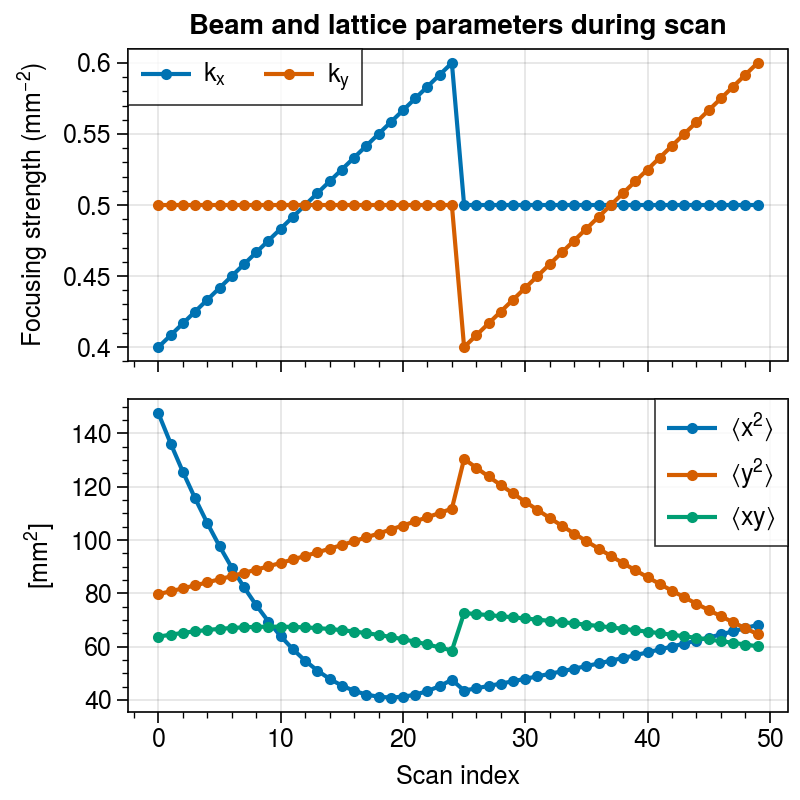

In [195]:
fig, axes = plot.subplots(nrows=2, figsize=(4, 4), spany=False)
axes[0].plot(k1_vals, marker='.')
axes[0].plot(k2_vals, marker='.')
for data in y.T:
    axes[1].plot(data, marker='.')
axes[0].legend(labels=['$k_x$', '$k_y$'])
axes[1].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], ncols=1);
axes.format(xlabel='Scan index', toplabels='Beam and lattice parameters during scan')
myplt.set_labels(axes, ['Focusing strength ($mm^{-2}$)', '[$mm^2$]'], 'ylabel')

Compute the least-squares solution to $\mathbf{A\sigma} = \mathbf{b}$.

In [201]:
lb = [0, 0, -np.inf, 0, 0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
ub = 10 * [np.inf]
result = opt.lsq_linear(A, b, bounds=(lb, ub), verbose=2)

The unconstrained solution is optimal.
Final cost 1.5515e-25, first-order optimality 4.25e-11


In [202]:
sigma = result.x
Sigma = get_mat(sigma)
show(Sigma, 'Sigma')
print()
show(Sigma0, 'Sigma0')
print()
show(Sigma - Sigma0, 'Sigma - Sigma0')

Sigma =
⎡59.572   45.87     0.0    14.523 ⎤
⎢                                 ⎥
⎢45.87   11.453   -10.759  10.779 ⎥
⎢                                 ⎥
⎢ 0.0    -10.759  44.131   -42.561⎥
⎢                                 ⎥
⎣14.523  10.779   -42.561  13.803 ⎦

Sigma0 =
⎡59.572  22.935     0.0    14.523 ⎤
⎢                                 ⎥
⎢22.935  11.453   -10.759  10.779 ⎥
⎢                                 ⎥
⎢ 0.0    -10.759  44.131   -21.281⎥
⎢                                 ⎥
⎣14.523  10.779   -21.281  13.803 ⎦

Sigma - Sigma0 =
⎡ 0.0    22.935    0.0      0.0  ⎤
⎢                                ⎥
⎢22.935   0.0      0.0      0.0  ⎥
⎢                                ⎥
⎢ 0.0     0.0      0.0    -21.281⎥
⎢                                ⎥
⎣ 0.0     0.0    -21.281    0.0  ⎦
